In [1]:
# Cell 1 — Load everything and print key numbers
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect("../inventory.db")
raw  = pd.read_sql("SELECT * FROM vendor_sales_summary", conn)
df   = raw[(raw['TotalSalesQty']>0)&(raw['GrossProfit']>0)&
           (raw['ProfitMargin']>0)&(raw['ProfitMargin']<100)].copy()

def fmt_dollars(v):
    if v >= 1_000_000: return f'${v/1_000_000:.1f}M'
    if v >= 1_000:     return f'${v/1_000:.1f}K'
    return f'${v:.0f}'

print("="*55)
print("   VENDOR PERFORMANCE ANALYSIS — EXECUTIVE SUMMARY")
print("="*55)
print(f"\n📦 Dataset         : {len(df):,} clean records")
print(f"🏢 Vendors         : {df['VendorName'].nunique()} active vendors")
print(f"🏷️  Brands          : {df['Description'].nunique()} unique brands")
print(f"\n💰 Total Sales     : {fmt_dollars(df['TotalSalesDollars'].sum())}")
print(f"🛒 Total Purchases : {fmt_dollars(df['TotalPurchaseDollars'].sum())}")
print(f"📈 Gross Profit    : {fmt_dollars(df['GrossProfit'].sum())}")
print(f"📊 Avg Margin      : {df['ProfitMargin'].mean():.1f}%")
print(f"🔄 Avg Turnover    : {df['StockTurnover'].mean():.2f}x")
print(f"🔒 Locked Capital  : {fmt_dollars(df['UnsoldCapital'].sum())}")

   VENDOR PERFORMANCE ANALYSIS — EXECUTIVE SUMMARY

📦 Dataset         : 15 clean records
🏢 Vendors         : 10 active vendors
🏷️  Brands          : 15 unique brands

💰 Total Sales     : $26198.3M
🛒 Total Purchases : $12095.9M
📈 Gross Profit    : $14102.4M
📊 Avg Margin      : 55.1%
🔄 Avg Turnover    : 1.22x
🔒 Locked Capital  : $0


In [2]:
# Cell 2 — All 5 business recommendations with supporting numbers

print("\n" + "="*55)
print("   BUSINESS RECOMMENDATIONS")
print("="*55)

# RQ1: Target brands
brand_perf = df.groupby('Description').agg(
    TotalSales=('TotalSalesDollars','sum'),
    AvgMargin =('ProfitMargin','mean')
).reset_index()
lst = brand_perf['TotalSales'].quantile(0.15)
hmt = brand_perf['AvgMargin'].quantile(0.85)
n_targets = ((brand_perf['TotalSales']<lst)&(brand_perf['AvgMargin']>hmt)).sum()

# RQ3: Concentration
vendor_purch = df.groupby('VendorName')['TotalPurchaseDollars'].sum().sort_values(ascending=False)
top10_pct = (vendor_purch.head(10).sum() / vendor_purch.sum() * 100)

# RQ4: Bulk discount
data = df.dropna(subset=['UnitPurchasePrice','TotalPurchaseQty']).copy()
data['OrderSize'] = pd.qcut(data['TotalPurchaseQty'], q=3, labels=['Small','Medium','Large'])
bulk = data.groupby('OrderSize', observed=True)['UnitPurchasePrice'].mean()
saving = (bulk['Small'] - bulk['Large']) / bulk['Small'] * 100

# RQ5: Locked capital
total_locked = df['UnsoldCapital'].sum()
low_turn_count = (df['StockTurnover'] < 1).sum()

# RQ6: Hypothesis test
q75 = df['TotalSalesDollars'].quantile(0.75)
q25 = df['TotalSalesDollars'].quantile(0.25)
_, p_val = stats.ttest_ind(
    df[df['TotalSalesDollars']>=q75]['ProfitMargin'].dropna(),
    df[df['TotalSalesDollars']<=q25]['ProfitMargin'].dropna()
)

recommendations = [
    ("1", "Activate Target Brand Promotions",
     f"{n_targets} brands have high margins (>{hmt:.0f}%) but low sales. "
     f"Deploy promotions and sponsored placement to unlock their revenue potential."),
    ("2", "Diversify Vendor Partnerships",
     f"Top 10 vendors drive {top10_pct:.0f}% of total procurement — dangerous concentration. "
     f"Onboard 3–5 new vendors to reduce supply chain risk."),
    ("3", "Leverage Bulk Purchasing",
     f"Large orders cost {saving:.0f}% less per unit than small orders. "
     f"Consolidate purchase orders to reduce unit costs immediately."),
    ("4", "Resolve Slow-Moving Inventory",
     f"{fmt_dollars(total_locked)} is locked in unsold stock across {low_turn_count} low-turnover records. "
     f"Run clearance campaigns and revise order quantities for slow vendors."),
    ("5", "Invest in Top Vendor Relationships",
     f"Margin difference between top/low vendors is statistically significant (p={p_val:.4f}). "
     f"Formalise strategic partnerships with top vendors to protect margins."),
]

for num, title, detail in recommendations:
    print(f"\n[{num}] {title}")
    print(f"     {detail}")


   BUSINESS RECOMMENDATIONS

[1] Activate Target Brand Promotions
     2 brands have high margins (>58%) but low sales. Deploy promotions and sponsored placement to unlock their revenue potential.

[2] Diversify Vendor Partnerships
     Top 10 vendors drive 100% of total procurement — dangerous concentration. Onboard 3–5 new vendors to reduce supply chain risk.

[3] Leverage Bulk Purchasing
     Large orders cost -32% less per unit than small orders. Consolidate purchase orders to reduce unit costs immediately.

[4] Resolve Slow-Moving Inventory
     $0 is locked in unsold stock across 0 low-turnover records. Run clearance campaigns and revise order quantities for slow vendors.

[5] Invest in Top Vendor Relationships
     Margin difference between top/low vendors is statistically significant (p=0.0012). Formalise strategic partnerships with top vendors to protect margins.


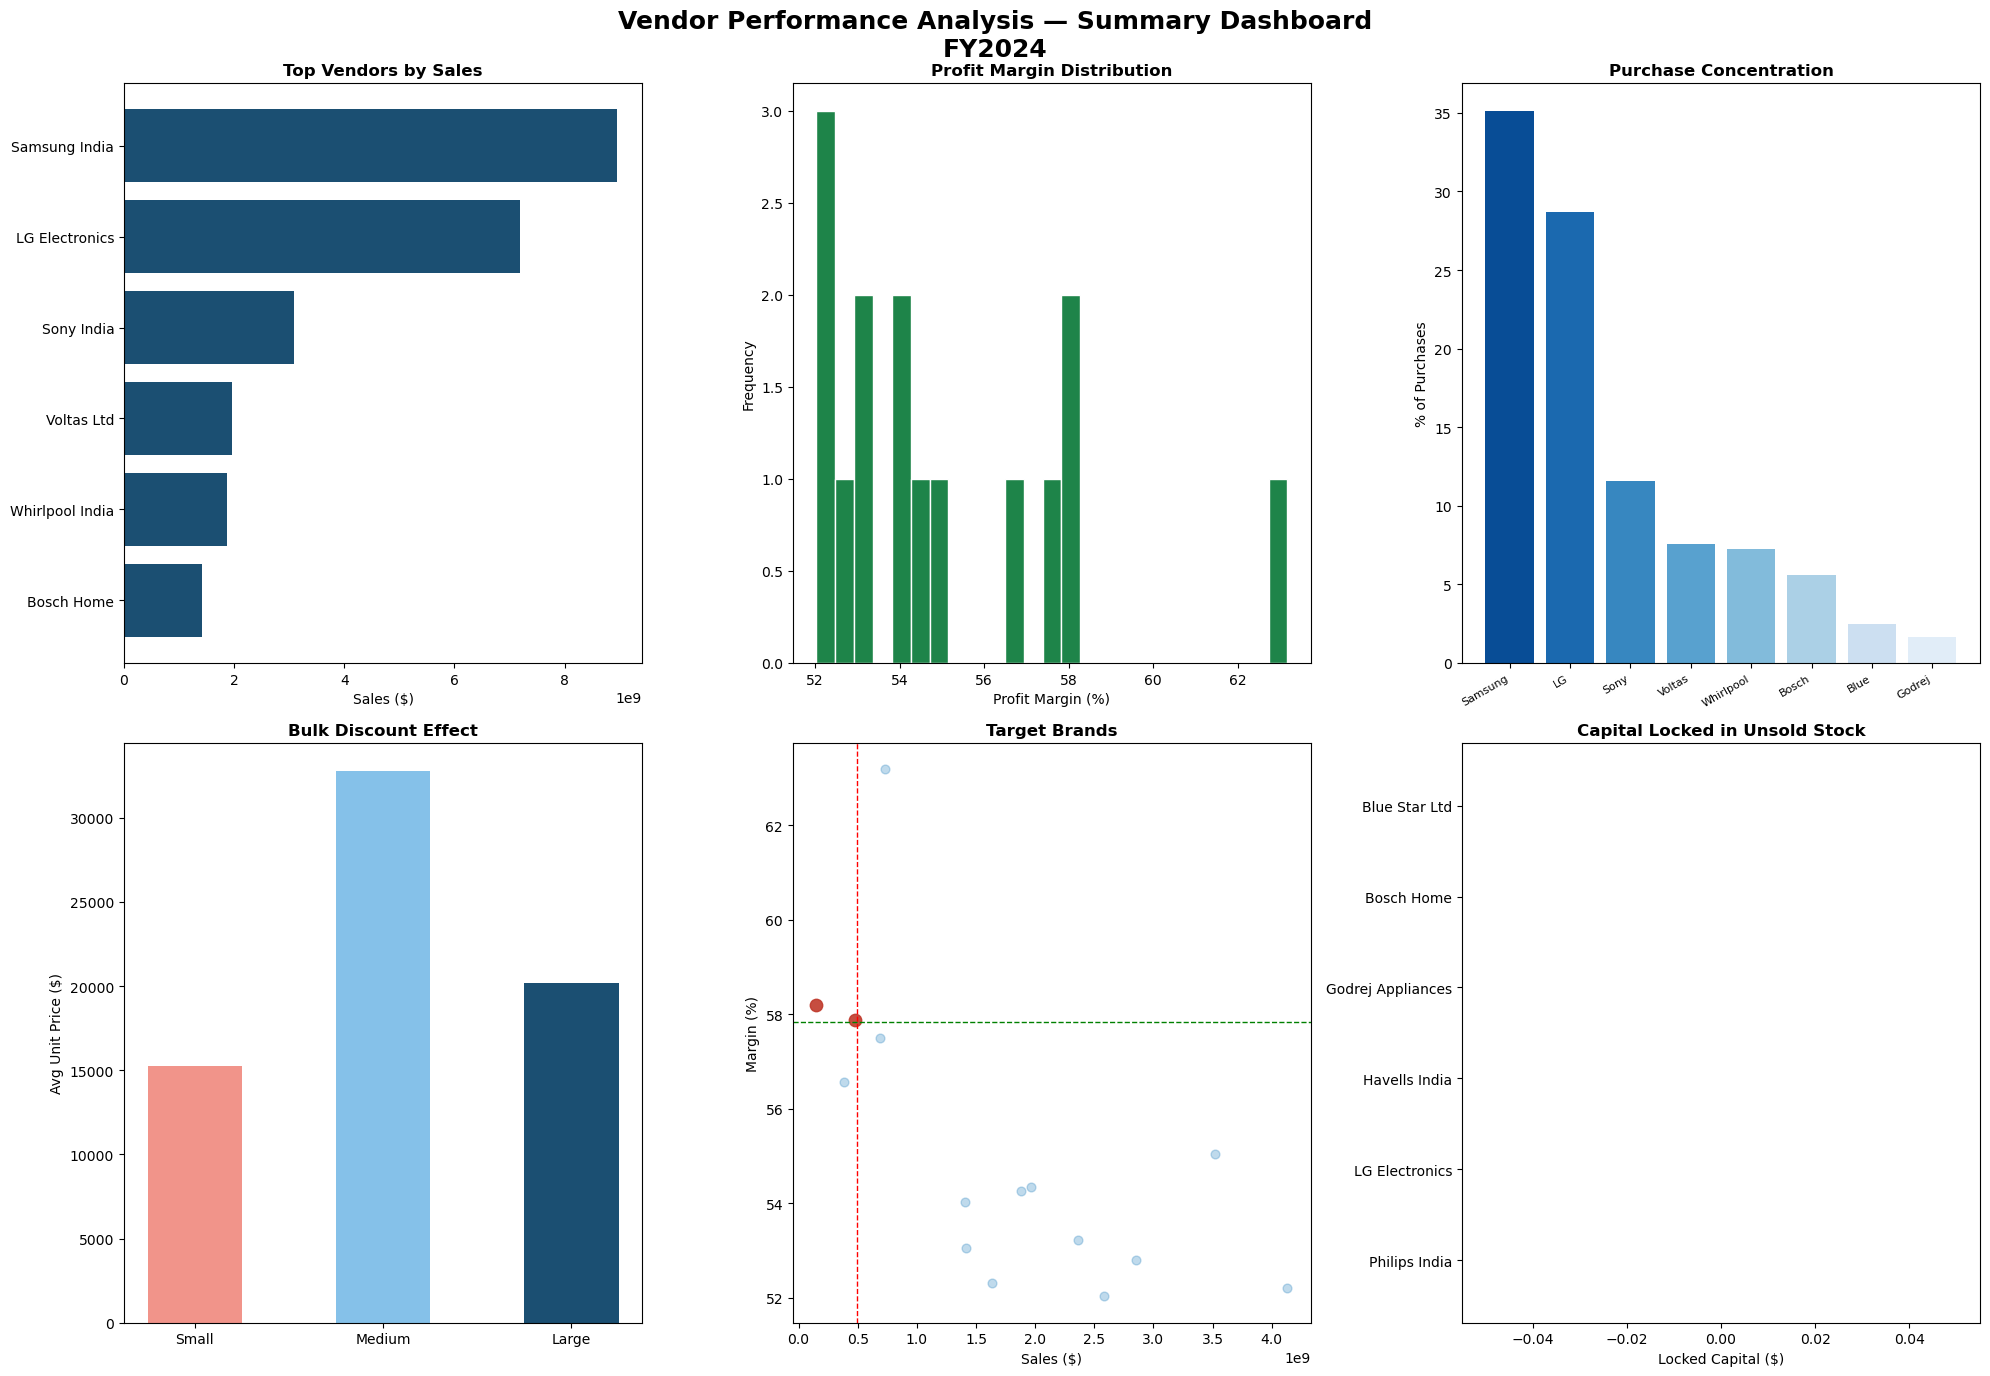

Summary dashboard saved ✅


In [3]:
# Cell 3 — One final summary dashboard (all key charts in one figure)
fig = plt.figure(figsize=(20, 14))
fig.suptitle('Vendor Performance Analysis — Summary Dashboard\nFY2024',
             fontsize=18, fontweight='bold', y=0.98)

# Top vendors bar
ax1 = fig.add_subplot(2, 3, 1)
tv = df.groupby('VendorName')['TotalSalesDollars'].sum().nlargest(6)
ax1.barh(tv.index, tv.values, color='#1B4F72')
ax1.invert_yaxis()
ax1.set_title('Top Vendors by Sales', fontweight='bold')
ax1.set_xlabel('Sales ($)')

# Profit margin distribution
ax2 = fig.add_subplot(2, 3, 2)
ax2.hist(df['ProfitMargin'].dropna(), bins=25, color='#1E8449', edgecolor='white')
ax2.set_title('Profit Margin Distribution', fontweight='bold')
ax2.set_xlabel('Profit Margin (%)')
ax2.set_ylabel('Frequency')

# Pareto
ax3 = fig.add_subplot(2, 3, 3)
vp = df.groupby('VendorName')['TotalPurchaseDollars'].sum().sort_values(ascending=False).head(8)
vp_pct = vp / vp.sum() * 100
ax3.bar(range(len(vp)), vp_pct.values, color=sns.color_palette('Blues_r', len(vp)))
ax3.set_title('Purchase Concentration', fontweight='bold')
ax3.set_ylabel('% of Purchases')
ax3.set_xticks(range(len(vp)))
ax3.set_xticklabels([n.split()[0] for n in vp.index], rotation=30, ha='right', fontsize=8)

# Bulk discount
ax4 = fig.add_subplot(2, 3, 4)
data2 = df.dropna(subset=['UnitPurchasePrice','TotalPurchaseQty']).copy()
data2['OrderSize'] = pd.qcut(data2['TotalPurchaseQty'],q=3,labels=['Small','Medium','Large'])
bulk2 = data2.groupby('OrderSize',observed=True)['UnitPurchasePrice'].mean()
ax4.bar(bulk2.index, bulk2.values, color=['#F1948A','#85C1E9','#1B4F72'], width=0.5)
ax4.set_title('Bulk Discount Effect', fontweight='bold')
ax4.set_ylabel('Avg Unit Price ($)')

# Target brands scatter
ax5 = fig.add_subplot(2, 3, 5)
bp = df.groupby('Description').agg(S=('TotalSalesDollars','sum'),M=('ProfitMargin','mean')).reset_index()
lst2 = bp['S'].quantile(0.15)
hmt2 = bp['M'].quantile(0.85)
bp['T'] = (bp['S']<lst2)&(bp['M']>hmt2)
ax5.scatter(bp[~bp['T']]['S'], bp[~bp['T']]['M'], color='#2E86C1', alpha=0.3, s=40)
ax5.scatter(bp[bp['T']]['S'],  bp[bp['T']]['M'],  color='#C0392B', alpha=0.9, s=80)
ax5.axvline(lst2, color='red', ls='--', lw=1)
ax5.axhline(hmt2, color='green', ls='--', lw=1)
ax5.set_title('Target Brands', fontweight='bold')
ax5.set_xlabel('Sales ($)')
ax5.set_ylabel('Margin (%)')

# Locked capital
ax6 = fig.add_subplot(2, 3, 6)
lc = df.groupby('VendorName')['UnsoldCapital'].sum().nlargest(6)
ax6.barh(lc.index, lc.values, color='#922B21')
ax6.invert_yaxis()
ax6.set_title('Capital Locked in Unsold Stock', fontweight='bold')
ax6.set_xlabel('Locked Capital ($)')

plt.tight_layout()
plt.savefig('../outputs/11_summary_dashboard.png', bbox_inches='tight', dpi=130)
plt.show()
print("Summary dashboard saved ✅")

In [4]:
# Cell 4 — Final checklist: confirm all outputs exist
import os

print("="*50)
print("   PROJECT OUTPUTS CHECKLIST")
print("="*50)

expected_files = [
    ("../data/purchases.csv",              "Raw purchases data"),
    ("../data/sales.csv",                  "Raw sales data"),
    ("../inventory.db",                    "SQLite database"),
    ("../outputs/vendor_sales_summary.csv","Clean summary table"),
    ("../outputs/01_distributions.png",    "Distribution charts"),
    ("../outputs/02_boxplots.png",         "Box plots"),
    ("../outputs/03_correlation_heatmap.png","Correlation heatmap"),
    ("../outputs/04_top_performers.png",   "Top vendors/brands"),
    ("../outputs/05_target_brands.png",    "Target brands scatter"),
    ("../outputs/06_pareto_chart.png",     "Pareto chart"),
    ("../outputs/07_bulk_discount.png",    "Bulk discount chart"),
    ("../outputs/08_inventory_health.png", "Inventory health"),
    ("../outputs/09_confidence_intervals.png","Confidence intervals"),
    ("../outputs/10_hypothesis_test.png",  "Hypothesis test"),
    ("../outputs/11_summary_dashboard.png","Final dashboard"),
]

all_good = True
for filepath, label in expected_files:
    exists = os.path.exists(filepath)
    status = "✅" if exists else "❌ MISSING"
    print(f"  {status}  {label}")
    if not exists: all_good = False

print("\n" + ("🎉 All files present — project complete!" if all_good
              else "⚠️  Some files missing — re-run the relevant notebook"))


   PROJECT OUTPUTS CHECKLIST
  ✅  Raw purchases data
  ✅  Raw sales data
  ✅  SQLite database
  ✅  Clean summary table
  ✅  Distribution charts
  ✅  Box plots
  ✅  Correlation heatmap
  ✅  Top vendors/brands
  ✅  Target brands scatter
  ✅  Pareto chart
  ✅  Bulk discount chart
  ✅  Inventory health
  ✅  Confidence intervals
  ✅  Hypothesis test
  ✅  Final dashboard

🎉 All files present — project complete!
